## Introduction
* Pathology의 전처리에 대해 실습해봅니다.
* Pathology의 경우 아주 큰 영상과 다양한 color distribution이 있습니다. 
* 대표적으로 Patch, Color normalization 대해 실습을 진행합니다.

캐글에 있는 데이터를 사용하기 위해 캐글의 노트북을 사용합니다.

만약 구글 코랩에서 이 코드를 따라오고자 한다면 아래 사이트를 참고하여 진행합니다.

https://poca.tistory.com/entry/캐글-데이터-셋-코랩에서-사용하기-kaggle-data-on-colab

사용 데이터는 

https://www.kaggle.com/competitions/prostate-cancer-grade-assessment/data

입니다. 

처음엔 저도 코랩을 통하여 진행하려했으나, 너무 데이터가 거대하기에 캐글 환경을 사용합니다.

In [1]:
!pip install staintools
!pip install spams-bin # 왜인지 spams의 경우 오류가 생김

In [2]:
## Path관련 library
from pathlib import Path # data path관련 

## WSI관련 library
import openslide # WSI 읽어오는 library ( 코랩의 경우 pip 필요 )
import cv2  # 기본적인 CV library 
import seaborn as sns # data analysis library

## etc
import pandas as pd # csv, dataframe 사용 library
import numpy as np 
import matplotlib.pyplot as plt # image visulization library

## color normalize
import staintools

In [3]:
# 우선적으로 datset을 읽어와줍니다. 
class cfg: 
    # Location of the training images
    BASE_PATH = '../input/prostate-cancer-grade-assessment'
    # image and mask directories
    data_dir = f'{BASE_PATH}/train_images'
    mask_dir = f'{BASE_PATH}/train_label_masks'
    # 간단히 읽어보는 연습을 할것이므로 mask 폴더는 기재하지 않음

In [4]:
# csv 파일을 읽어 data의 경로를 확인합니다 
train = pd.read_csv(f'{cfg.BASE_PATH}/train.csv')
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [5]:
# 이미지 아이디 베이스로 경로 매칭 시켜줌.
train['img_path'] = train['image_id'].apply(lambda x : Path(cfg.data_dir)/ (x+'.tiff'))
train.head()

,image_id,data_provider,isup_grade,gleason_score,img_path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,../input/prostate-cancer-grade-assessment/trai...
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,../input/prostate-cancer-grade-assessment/trai...
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...


In [6]:
train['img_path'][0]

PosixPath('../input/prostate-cancer-grade-assessment/train_images/0005f7aaab2800f6170c399693a96917.tiff')

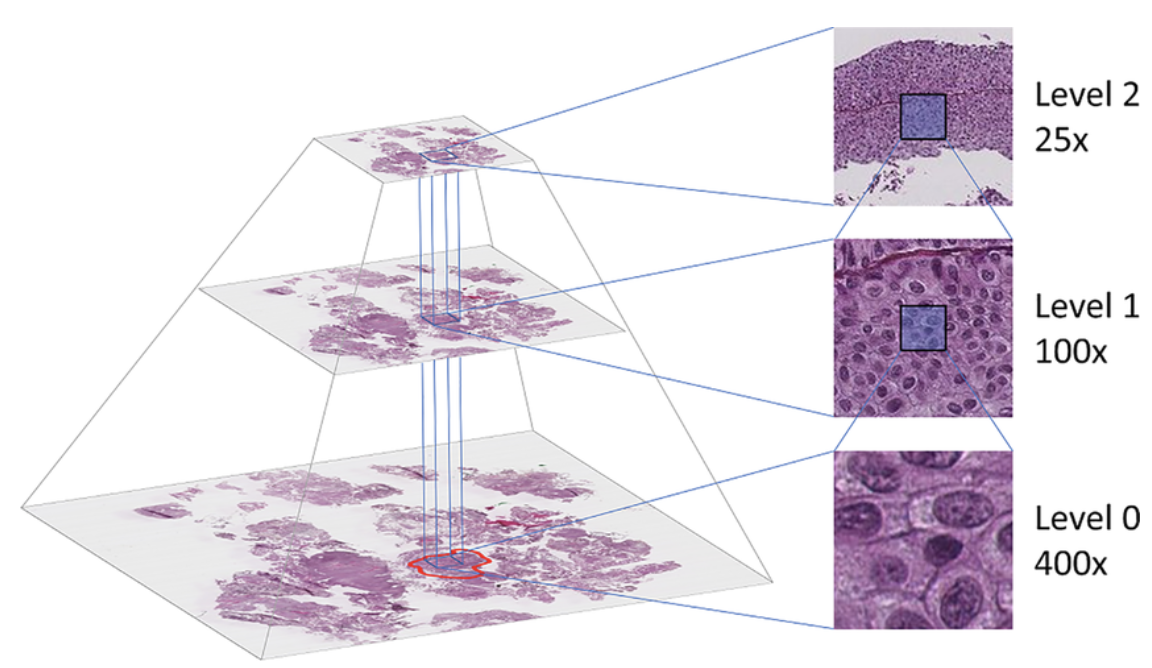
* Pathology의 영상같은 경우 위와 같이 되어있다. 
* 우리가 얻어지는 Level에 따라서 size가 달라지며 영상의 pixel간의 distance가 다르다. 

In [7]:
image = openslide.OpenSlide(train.loc[0,'img_path']) # openslid로 tiff 읽기 
max_level = image.level_count   # 가장 해상도가 적은 image 순서 가져오기  
print(image.level_dimensions, image.level_count)
level = max_level - 3
small_patch = image.read_region((7100,10000), level, (1024,1024)) #r 

level = max_level - 2
minum_patch = image.read_region((7100//pow(2,1),10000//pow(2,1)), level, (1024,1024)) #r 

level = max_level - 1
min_size = image.level_dimensions[level]
large_patch = image.read_region((7100//pow(2,3),10000//pow(2,3)), level, (1024,1024)) #r 



((27648, 29440), (6912, 7360), (1728, 1840)) 3


* openslide read region에 방법은 다음과 같다. 
* location : 영상이 시작되어지는 위치 
* level : Pyramid 영상중에 어떠한 Level를 선택할지 
* size : 영상의 크기
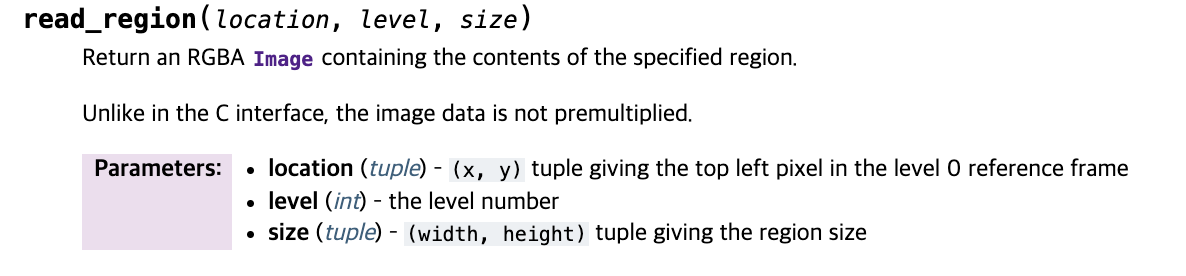

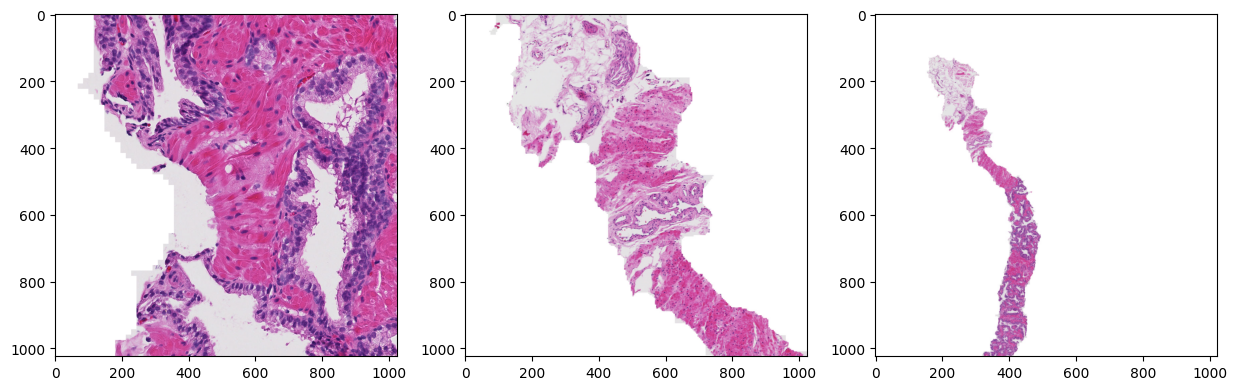

In [8]:
f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(small_patch)
ax[1].imshow(minum_patch)
ax[2].imshow(large_patch)


# 전처리
# Tile (Patching)
* 우리가 아는 openslide의 경우 다양한 image를 읽어올수 있지만 읽어오는 속도가 느리다. 
* 이를 해결하고자 `skimage`를 사용하여 이미지를 읽어오도록 한다. 


* Patch로 자르기 이전에 pathology image에서는 white즉 흰공간이 너무 많다.
* 이를 제거해주는 간편한 코드를 사용해본다. 

In [9]:
import skimage
import openslide 
%time image_a = openslide.OpenSlide(train.loc[0,'img_path'])
%time image_b = skimage.io.MultiImage(str(train.loc[0,'img_path']))

CPU times: user 3.37 ms, sys: 3.05 ms, total: 6.41 ms
Wall time: 24.5 ms
CPU times: user 31.2 ms, sys: 5.01 ms, total: 36.2 ms
Wall time: 36.1 ms


In [10]:
level = max_level - 1
min_size = image_a.level_dimensions[level]
large_patch = image_a.read_region((0,0), level, min_size) #r 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

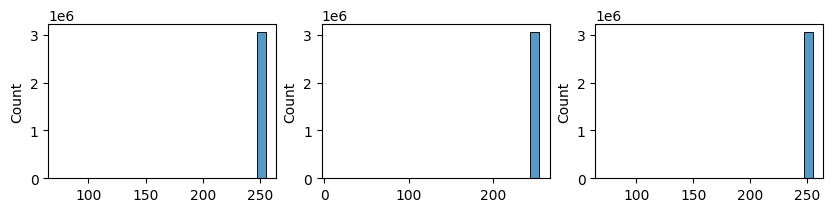

In [11]:
## int8로 되어있음. 
fig, ax = plt.subplots(1,3, figsize=(10,2))
sns.histplot(np.array(large_patch)[...,0].ravel(), ax=ax[0])
sns.histplot(np.array(large_patch)[...,1].ravel(), ax=ax[1])
sns.histplot(np.array(large_patch)[...,2].ravel(), ax=ax[2])

RGB 히스토그램을 보면 대부분 250정도에 몰려있음. 즉 화이트 스페이스 부분은 0 일것임.

In [12]:
## crop white region
def crop_white(image: np.ndarray) -> np.ndarray:
    assert image.shape[2] == 3
    assert image.dtype == np.uint8
    ys, = (image.min((1, 2)) != 255).nonzero()
    xs, = (image.min(0).min(1) != 255).nonzero()
    if len(xs) == 0 or len(ys) == 0:
        return image
    return image[ys.min():ys.max() + 1, xs.min():xs.max() + 1]

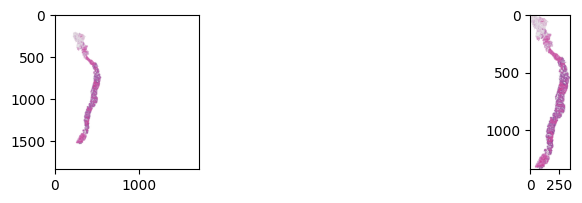

In [13]:
rm_white_img = crop_white(np.array(large_patch)[...,:3])
fig, ax = plt.subplots(1,2, figsize=(10,2))
ax[0].imshow(large_patch)
ax[1].imshow(rm_white_img)

In [14]:
import math
import cv2
sz = 256 # 사이즈
pad = 128 # 움직일 패드
N=9 # 몇개 뽑을건지 설정
def tile(img):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    print([[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]])
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img

def concate_images(img): 
    assert len(img.shape) == 4
    assert img.shape[0] == N
    ax_size = int(math.sqrt(N))
    order_index = np.arange(0,N).reshape(ax_size,ax_size)
    hconcat = [cv2.hconcat(img[i]) for i in order_index]
    con_img = cv2.vconcat(hconcat)
    return con_img

In [15]:
!pip install imagecodecs

In [16]:
remove_image_b = crop_white(np.array(image_b)[0]) # white 의 값을 제거 
tile_images = tile(remove_image_b) #Patch로 나눔
concate_img = concate_images(tile_images) #다시 vis concate

[[0, 0], [88, 88], [0, 0]]


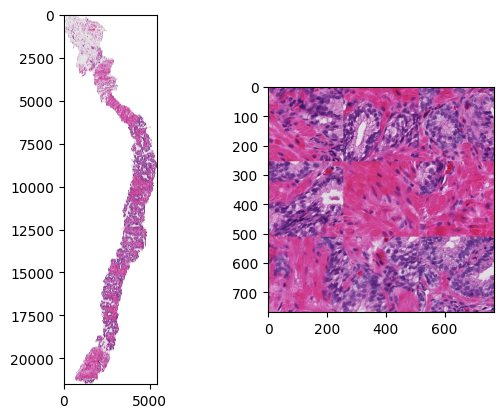

In [17]:
fig,axs = plt.subplots(1,2)
axs[0].imshow(remove_image_b)
axs[1].imshow(concate_img)

del remove_image_b, image_b, concate_img


## Color normalization
* 일반적으로 Pathology image는 색의 분포가 다르다. 
* 이를 맞춰주는 작업도 필요하다.(학습시 필수는 아니다) 


In [22]:
data_type = train['data_provider'].unique()
print(data_type)

kar_img_path = train[train['data_provider'] == data_type[0]].reset_index(drop=True).loc[0,'img_path']
rad_img_path = train[train['data_provider'] == data_type[1]].reset_index(drop=True).loc[0,'img_path']

kar_img = skimage.io.MultiImage(str(kar_img_path))
rad_img = skimage.io.MultiImage(str(rad_img_path))

remove_image_b = crop_white(np.array(kar_img)[0])
tile_kar_images = concate_images(tile(remove_image_b))

remove_image_b = crop_white(np.array(rad_img)[0])
tile_rad_images = concate_images(tile(remove_image_b))


['karolinska' 'radboud']
[[0, 0], [88, 88], [0, 0]]
[[12, 12], [76, 76], [0, 0]]


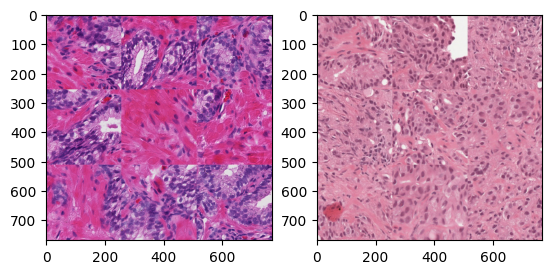

In [19]:
fig,axs = plt.subplots(1,2)
axs[0].imshow(tile_kar_images)
axs[1].imshow(tile_rad_images)

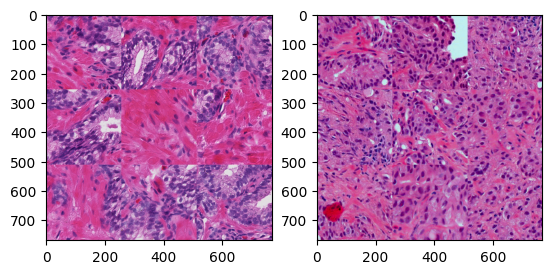

In [20]:
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(tile_kar_images))
reinhard_normalized = normalizer.transform(np.array(tile_rad_images))
fig,axs = plt.subplots(1,2)
axs[0].imshow(tile_kar_images)
axs[1].imshow(reinhard_normalized)


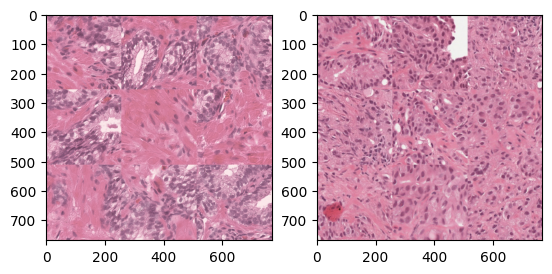

In [21]:
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(tile_rad_images))
reinhard_normalized = normalizer.transform(np.array(tile_kar_images))
fig,axs = plt.subplots(1,2)
axs[0].imshow(reinhard_normalized)
axs[1].imshow(tile_rad_images)
